## Customer Churn Modelling using H2OAutoML

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

import h2o
from h2o.automl import H2OAutoML

# Start the H2O cluster (locally)
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "20" 2023-03-21; OpenJDK Runtime Environment Zulu20.28+85-CA (build 20+36); OpenJDK 64-Bit Server VM Zulu20.28+85-CA (build 20+36, mixed mode, sharing)
  Starting server from /Users/Michael_Enudi/opt/anaconda3/envs/h2o_env/lib/python3.8/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmph50rtq7h
  JVM stdout: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmph50rtq7h/h2o_Michael_Enudi_started_from_python.out
  JVM stderr: /var/folders/xl/w9y4tjx938vdwtkgzwxsxx8m0000gp/T/tmph50rtq7h/h2o_Michael_Enudi_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Africa/Johannesburg
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.40.0.4
H2O_cluster_version_age:    1 month and 30 days
H2O_cluster_name:           H2O_from_python_Michael_Enudi_2k2f1p
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    12
H2O_cluster_allowed_cores:  12
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.8.16 final
--------------------------  ------------------------------------

### Data Ingestion

In [2]:
data = pd.read_csv('../../data/Customer_Churn_Dataset.csv')
print(data.shape)
data.head()

(10000, 14)


RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [3]:
# we can agree that RowNumber, CustomerId and Surnameoffer no predictive values. So we will remove them
label = 'Exited'
data.drop(columns=['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace=True)
data[label] = data[label].astype('category')
data.head()

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary Exited  
0          1               1        101348.88      1  
1          0               1        112542.58      0  
2          1               0        113931.57      1  
3          0               0         93826.63      0  
4          1               1         79084.10      0

### Data analysis

In [4]:
# summary statistics
data.describe()

CreditScore           Age        Tenure        Balance  NumOfProducts  \
count  10000.000000  10000.000000  10000.000000   10000.000000   10000.000000   
mean     650.528800     38.921800      5.012800   76485.889288       1.530200   
std       96.653299     10.487806      2.892174   62397.405202       0.581654   
min      350.000000     18.000000      0.000000       0.000000       1.000000   
25%      584.000000     32.000000      3.000000       0.000000       1.000000   
50%      652.000000     37.000000      5.000000   97198.540000       1.000000   
75%      718.000000     44.000000      7.000000  127644.240000       2.000000   
max      850.000000     92.000000     10.000000  250898.090000       4.000000   

         HasCrCard  IsActiveMember  EstimatedSalary  
count  10000.00000    10000.000000     10000.000000  
mean       0.70550        0.515100    100090.239881  
std        0.45584        0.499797     57510.492818  
min        0.00000        0.000000        11.580000  
25%        0.00000        0.000000     51002.110000  
50%        1.00000        1.000000    100193.915000  
75%        1.00000        1.000000    149388.247500  
max        1.00000        1.000000    199992.480000

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   CreditScore      10000 non-null  int64   
 1   Geography        10000 non-null  object  
 2   Gender           10000 non-null  object  
 3   Age              10000 non-null  int64   
 4   Tenure           10000 non-null  int64   
 5   Balance          10000 non-null  float64 
 6   NumOfProducts    10000 non-null  int64   
 7   HasCrCard        10000 non-null  int64   
 8   IsActiveMember   10000 non-null  int64   
 9   EstimatedSalary  10000 non-null  float64 
 10  Exited           10000 non-null  category
dtypes: category(1), float64(2), int64(6), object(2)
memory usage: 791.3+ KB


([<matplotlib.patches.Wedge at 0x7fec57178e50>,
 [Text(-0.8823431426537007, 0.6568642010431011, ''),
  Text(0.8823431426537006, -0.6568642010431012, '')])

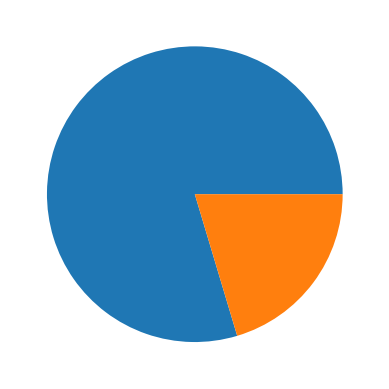

In [6]:
# distribution of exited classes
plt.pie(data[label].value_counts())

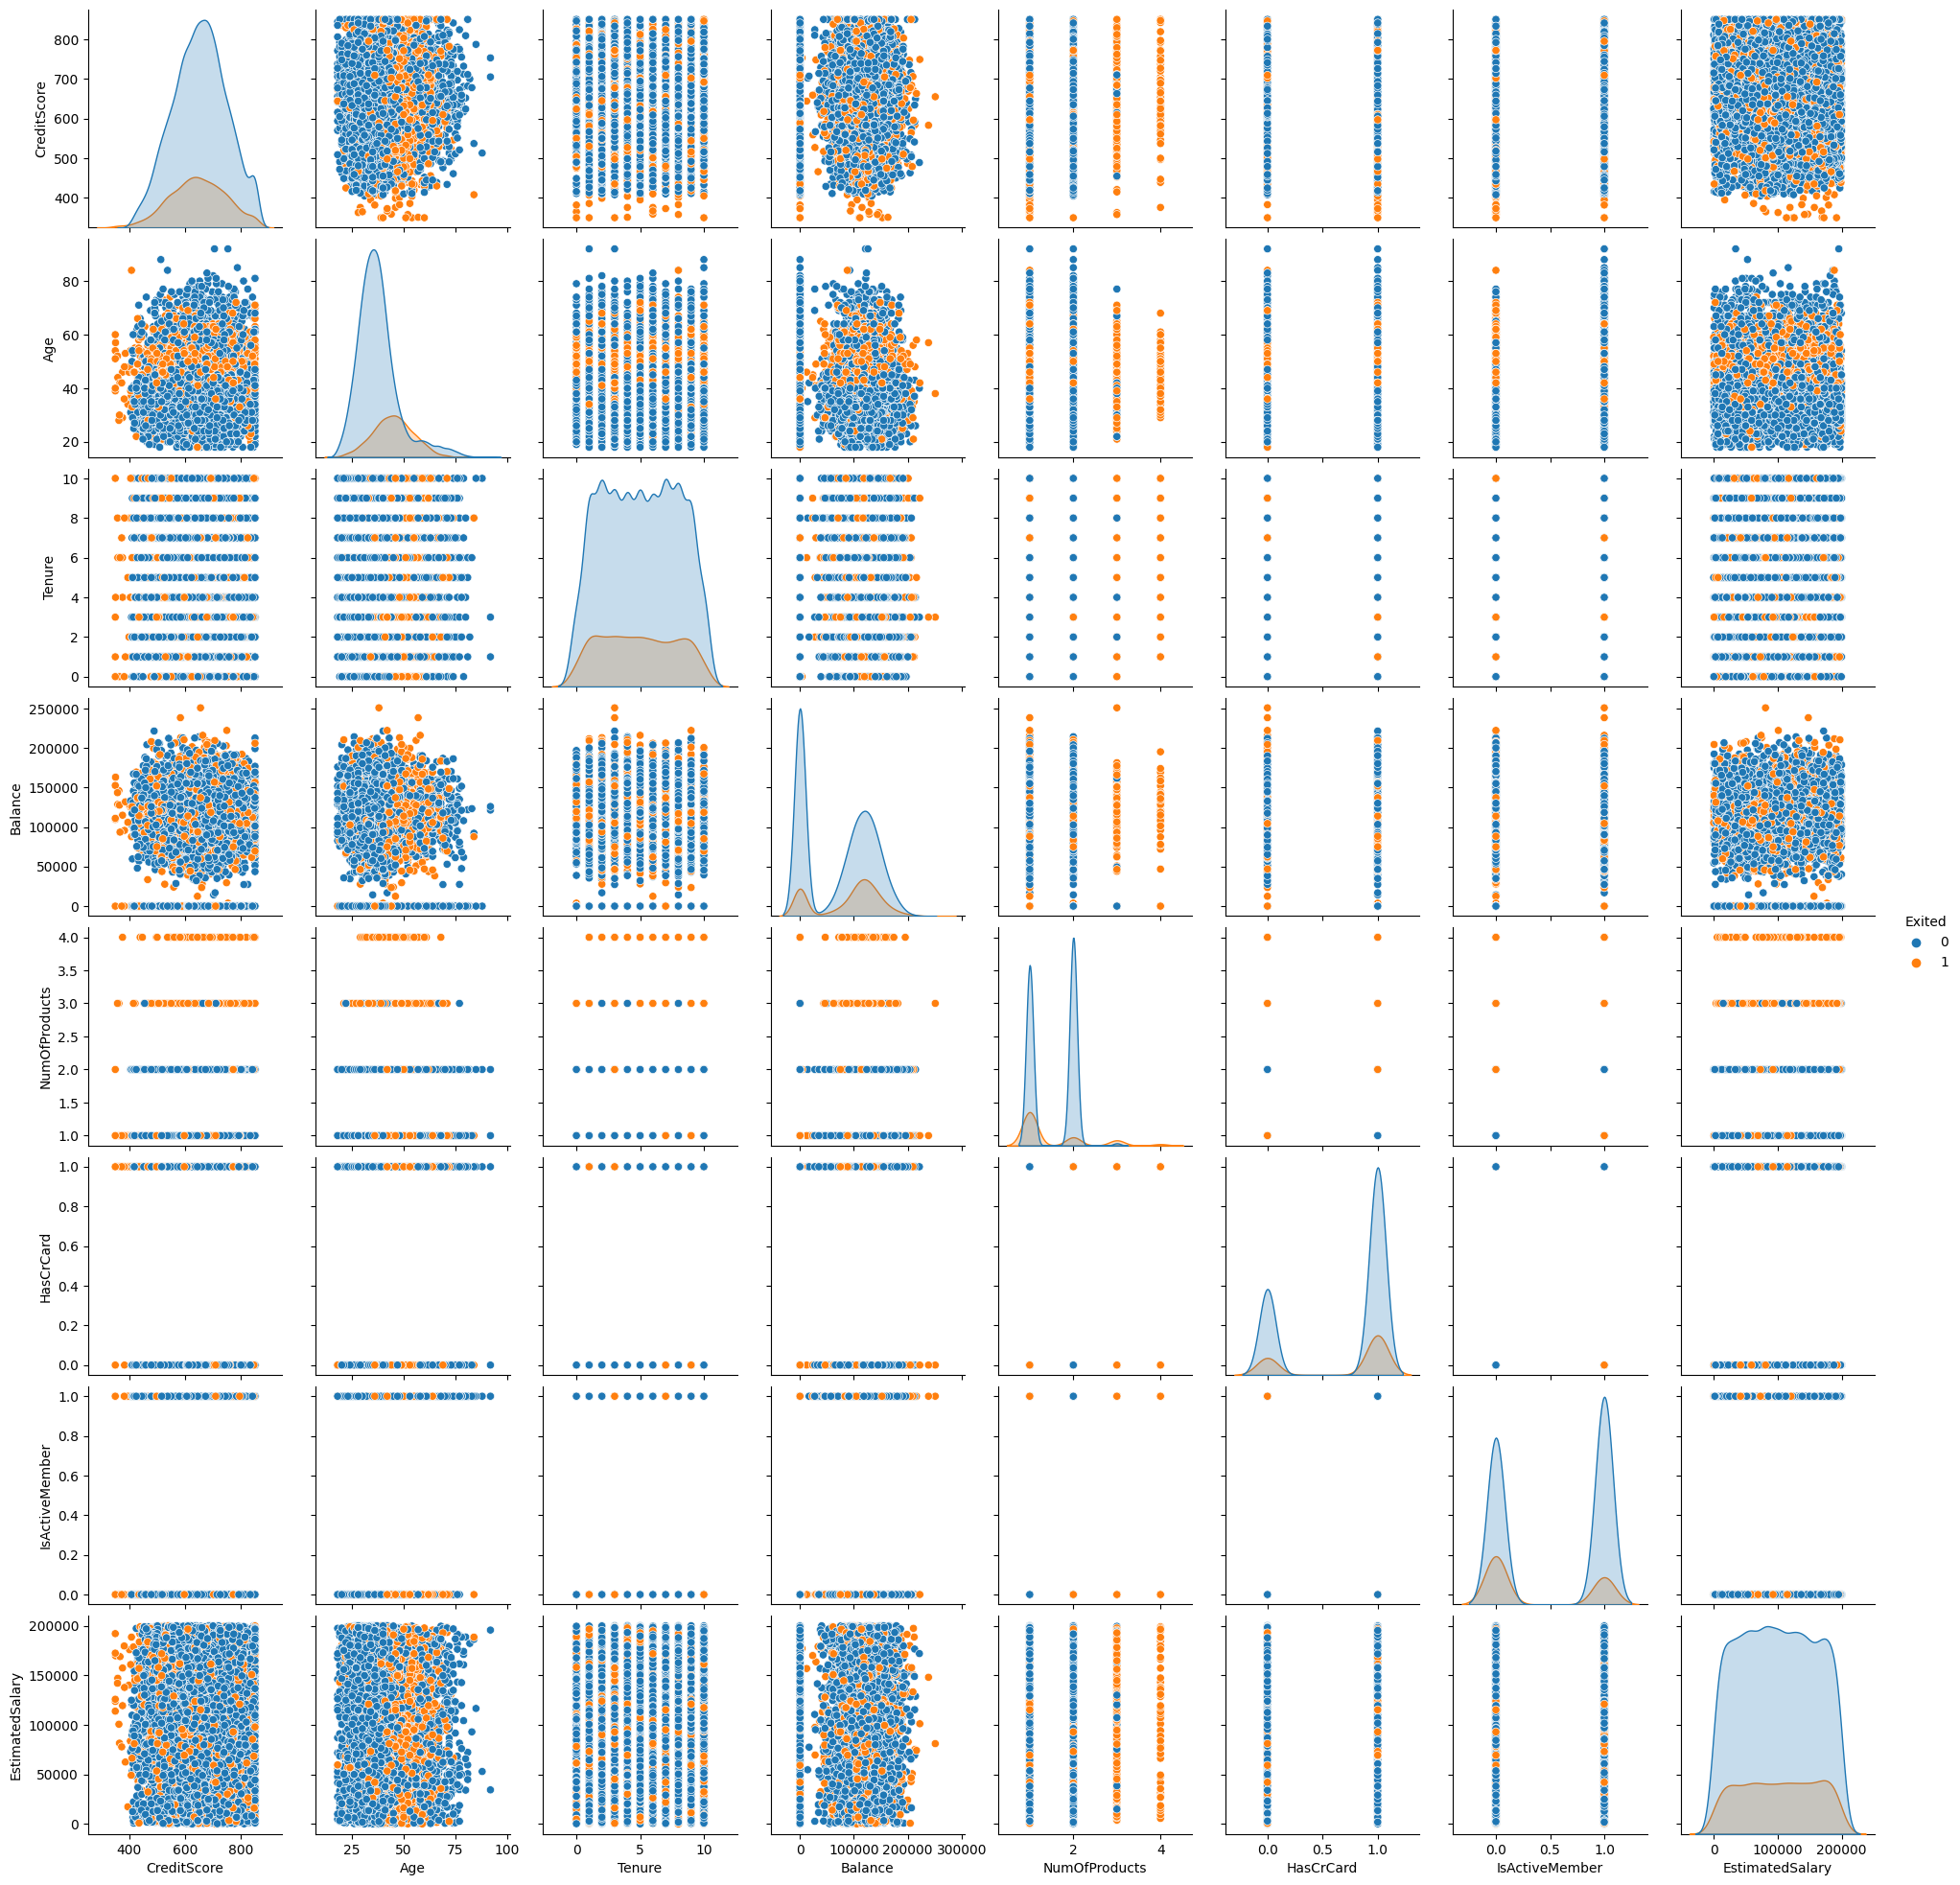

In [7]:
sns.pairplot(data, hue=label)

### Model training

In [8]:
class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [9]:
multi_col_label_encoder = MultiColumnLabelEncoder(columns=['Geography', 'Gender', 'Age'])
data[['Geography', 'Gender', 'Age']] = multi_col_label_encoder.transform(data[['Geography', 'Gender', 'Age']])
data.head()

CreditScore  Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619          0       0   24       2       0.00              1   
1          608          2       0   23       1   83807.86              1   
2          502          0       0   24       8  159660.80              3   
3          699          0       0   21       1       0.00              2   
4          850          2       0   25       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary Exited  
0          1               1        101348.88      1  
1          0               1        112542.58      0  
2          1               0        113931.57      1  
3          0               0         93826.63      0  
4          1               1         79084.10      0

In [10]:
## split test and train as well as dep and indep variable
# Identify predictors and response
Xs = [x for x in data.columns if x != label]

stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=1)
for i, (train_index, test_index) in enumerate(stratified_shuffle_split.split(data,data[label])):
    train = data.iloc[train_index]
    test = data.iloc[test_index]
    
train_frame = h2o.H2OFrame(train)
train_frame[label] = train_frame[label].asfactor()

test_frame = h2o.H2OFrame(test.drop(columns=[label]))

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
aml = H2OAutoML(seed=1)
aml.train(x=Xs, y=label, training_frame=train_frame)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20230628_93717


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       5/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           2/2
# GLM base models (used / total)           0/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.08703792652813852
RMSE: 0.2950219085561927
LogLoss: 0.28664243869197703
AUC: 0.910587558959572
AUCPR: 0.7801363010038597
Gini: 0.821175117919144
Null degrees of freedom: 8499
Residual degrees of freedom: 8494
Null deviance: 8592.088022754233
Residual deviance: 4872.9214577636085
AIC: 4884.9214577636085

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2957921330773462
       0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      6128  641   0.0947   (641.0/6769.0)
1      489   1242  0.2825   (489.0/1731.0)
Total  6617  1883  0.1329   (1130.0/8500.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.295792     0.687327  209
max f2                       0.165866     0.759794  268
max f0point5                 0.548403     0.747157  123
max accuracy                 0.475497     0.882     146
max precision                0.998524     1         0
max recall                   0.00828631   1         395
max specificity              0.998524     1         0
max absolute_mcc             0.418602     0.606901  165
max min_per_class_accuracy   0.198668     0.829001  251
max mean_per_class_accuracy  0.217503     0.831579  242
max tns                      0.998524     6769      0
max fns                      0.998524     1721      0
max fps                      0.00449029   6769      399
max tps                      0.00828631   1731      395
max tnr                      0.998524     1         0
max fnr                      0.998524     0.994223  0
max fpr                      0.00449029   1         399
max tpr                      0.00828631   1         395

Gains/Lift Table: Avg response rate: 20,36 %, avg score: 20,11 %
group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.01                        0.978341           4.91046    4.91046            1                0.990615   1                           0.990615            0.0491046       0.0491046                  391.046   391.046            0.0491046
2        0.02                        0.938831           4.91046    4.91046            1                0.956856   1                           0.973735            0.0491046       0.0982091                  391.046   391.046            0.0982091
3        0.03                        0.91002            4.73715    4.85269            0.964706         0.923408   0.988235                    0.956959            0.0473715       0.145581                   373.715   385.269            0.145137
4        0.

In [13]:
lb = aml.leaderboard
lb

model_id                                                                      auc    logloss     aucpr    mean_per_class_error      rmse       mse
-----------------------------------------------------------------------  --------  ---------  --------  ----------------------  --------  --------
StackedEnsemble_BestOfFamily_4_AutoML_1_20230628_93717                   0.86698    0.333122  0.703731                0.228906  0.31868   0.101557
StackedEnsemble_BestOfFamily_6_AutoML_1_20230628_93717                   0.866806   0.333047  0.704153                0.230001  0.318673  0.101553
StackedEnsemble_AllModels_3_AutoML_1_20230628_93717                      0.86665    0.332902  0.705202                0.227582  0.318299  0.101314
StackedEnsemble_AllModels_6_AutoML_1_20230628_93717                      0.865462   0.333709  0.704222                0.227031  0.318727  0.101587
StackedEnsemble_Best1000_1_AutoML_1_20230628_93717                       0.865276   0.33384   0.704243                0.230585  0.318811  0.10164
StackedEnsemble_AllModels_4_AutoML_1_20230628_93717                      0.865145   0.33408   0.703454                0.226177  0.318909  0.101703
StackedEnsemble_AllModels_2_AutoML_1_20230628_93717                      0.86468    0.33518   0.700949                0.225638  0.319498  0.102079
GBM_grid_1_AutoML_1_20230628_93717_model_9                               0.864072   0.337439  0.697235                0.225067  0.320576  0.102769
XGBoost_lr_search_selection_AutoML_1_20230628_93717_select_grid_model_3  0.863887   0.338483  0.692279                0.226667  0.320947  0.103007
XGBoost_grid_1_AutoML_1_20230628_93717_model_15                          0.863838   0.338594  0.692488                0.22453   0.320955  0.103012
[187 rows x 7 columns]

In [14]:
# best_model = aml.get_best_model() 
# # Get the best model using a non-default metric
# best_model = aml.get_best_model(criterion="logloss")
# # Get the best XGBoost model using default sort metric
# best_xgb_model = aml.get_best_model(algorithm="xgboost")
# # Get the best XGBoost model, ranked by logloss
# best_xgb_model = aml.get_best_model(algorithm="xgboost", criterion="logloss")
# # Get a specific model by model ID
# best_model = h2o.get_model("StackedEnsemble_BestOfFamily_AutoML_20191213_174603")

best_model = aml.leader # equivalent of aml.get_best_model()  

In [15]:
def display_metrics(y_true, y_pred):
    print("Accuracy score:", round(accuracy_score(y_true, y_pred),4))
    print("Precision score:", round(precision_score(y_true, y_pred),4))
    print("Recall score:", round(recall_score(y_true, y_pred),4))
    print("F1 score:", round(f1_score(y_true, y_pred),4))
    print("Confusion matrix \n")
    print(confusion_matrix(y_true=y_true, y_pred=y_pred))

In [18]:
y_train_prediction = best_model.predict(train_frame)
y_train_class_pred = y_train_prediction['predict'].as_data_frame()['predict']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [20]:
display_metrics(train[label], y_train_class_pred)

Accuracy score: 0.8676
Precision score: 0.6627
Recall score: 0.7129
F1 score: 0.6869
Confusion matrix 

[[6141  628]
 [ 497 1234]]


### Testing and evaluation

In [21]:
y_prediction = best_model.predict(test_frame)
y_class_pred = y_prediction['predict'].as_data_frame()['predict']

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


In [22]:
display_metrics(test[label], y_class_pred)

Accuracy score: 0.846
Precision score: 0.6214
Recall score: 0.6275
F1 score: 0.6244
Confusion matrix 

[[1077  117]
 [ 114  192]]


### Model explainability

In [24]:
best_model.explain(test_frame)

### persist model to disk

In [35]:
best_model.save_model_details(...)

Signature: best_model.save_model_details(path='', force=False, filename=None)
Docstring:
Save Model Details of an H2O Model in JSON Format to disk.

:param path: a path to save the model details at (e.g. hdfs, s3, local).
:param force: if ``True``, overwrite destination directory in case it exists, or throw exception if set to ``False``.
:param filename: a filename for the saved model (file type is always .json).

:returns str: the path of the saved model details
File:      ~/opt/anaconda3/envs/h2o_env/lib/python3.8/site-packages/h2o/model/model_base.py
Type:      method